In [134]:
from invisible_cities.cities.components import wf_from_files, WfType
from invisible_cities.cities.components import deconv_pmt, calibrate_pmts, get_pmt_wfs, load_dst
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tables as tb
import os
from scipy.optimize import curve_fit
from matplotlib.cm import get_cmap
from mpl_interactions import ioff, panhandler, zoom_factory

from scipy.signal import convolve

# Select the KDST

Here we look at events with a matching S1 and S2

In [278]:
kdst = pd.read_hdf("DEMO_Slim.h5","kdst")
display(kdst)
wfms = pd.read_hdf("DEMO_Slim.h5","wfm")
wfms['times'] = wfms['times'].astype(float)
display(wfms)
print(wfms.event.unique())

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
529,243585,1.686319e+09,0,0,1,1,200.0,4.604781,23.221897,151525.0,...,109,252.967484,252.967484,1.734042,48.001316,30.617051,56.934437,0.567778,27.785613,25.425956
681,243630,1.686319e+09,0,0,1,1,125.0,1.809542,6.890528,151250.0,...,59,252.256424,252.256424,1.690632,-12.168236,-53.309538,54.680644,-1.795208,19.786410,27.359551
727,243647,1.686319e+09,0,0,1,1,125.0,2.129465,7.849839,333600.0,...,63,309.885590,309.885590,1.968157,38.696795,29.227846,48.494422,0.646887,19.362204,20.822376
761,243657,1.686319e+09,0,0,1,1,150.0,3.807471,13.354649,333300.0,...,80,70.171753,70.171753,1.129120,-22.667181,37.646932,43.944199,2.112758,22.231899,19.698418
772,243661,1.686319e+09,0,0,1,1,125.0,1.938589,6.769459,122275.0,...,86,282.215210,282.215210,1.809884,-10.273464,-15.353004,18.473192,-2.160516,22.533572,25.114597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8181,254404,1.686319e+09,0,0,1,1,150.0,2.003214,8.136253,173575.0,...,80,230.901733,230.901733,1.692743,-17.572494,-12.285485,21.441215,-2.531450,22.947762,21.639030
8182,254405,1.686319e+09,0,0,1,1,150.0,1.804700,7.292423,205325.0,...,55,199.149475,199.149475,1.631500,-32.121694,-29.169228,43.389481,-2.404329,21.378503,19.074921
8239,254428,1.686319e+09,0,0,1,1,150.0,2.044225,8.789826,232550.0,...,71,171.957443,171.957443,1.511900,-12.865438,-32.089526,34.572492,-1.952098,21.628728,22.965030
8260,254439,1.686319e+09,0,0,1,1,125.0,3.491424,12.731092,129425.0,...,75,275.064484,275.064484,1.820509,-8.197052,-12.402134,14.866223,-2.154823,21.024328,20.697632


,times,sumwf,z,event
15801,395.025,0.182604,61.455658,38760
15802,395.050,-0.243129,61.455658,38760
15803,395.075,-0.185028,61.455658,38760
15804,395.100,-0.243131,61.455658,38760
15805,395.125,-0.187922,61.455658,38760
...,...,...,...,...
16595,414.875,-0.055524,124.065971,22046
16596,414.900,0.309650,124.065971,22046
16597,414.925,-0.063139,124.065971,22046
16598,414.950,-0.007496,124.065971,22046


[38760 38761 38766 ... 22009 22014 22046]


In [463]:
# Fit the distribution 
def Gaussian_(x, A, mu, sigma):
    return A * np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

def DiffModel(t, DL, DT, r0, z, v,sigma0):
    A = ( (z + v*t)*DL + (sigma0*v)**2) / (sigma0**2 + 2*DL*t)**1.5
    B = 1 - np.exp(-r0**2 / (4*DT*t))
    C = np.exp(- (z - v*t)**2 / (2*(sigma0**2 + 2*DL*t)) )
    return A * B * C / max( A * B * C)


def GausModel(t, DL, z, v, mu, sigma0):
    sigma = np.sqrt(2*DL*z/v) 
    Gauss = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-((t-mu)**2)/(2*sigma**2))
    return Gauss/max(Gauss)

# Function to return the DEMO timing shape
def GetDEMOTimingShape(t, shift):

    width = 1.5
    # width=1.4
    square_pulse = np.where((t-shift >= -width) & (t-shift <= width+0.03), 1, 0) # a width of ~3 mus gives a good match

    # Convolve Gaussian with square pulse
    gaussian = Gaussian_(t, 1, shift, 0.25) # 0.25 sigma width seems to give a good match to the simulation form

    convolution = convolve(gaussian, square_pulse, mode='same')
    convolution = 858.0 * convolution/max(convolution) ## 858 is a custom designed multiplication factor based on the simulation
    return convolution



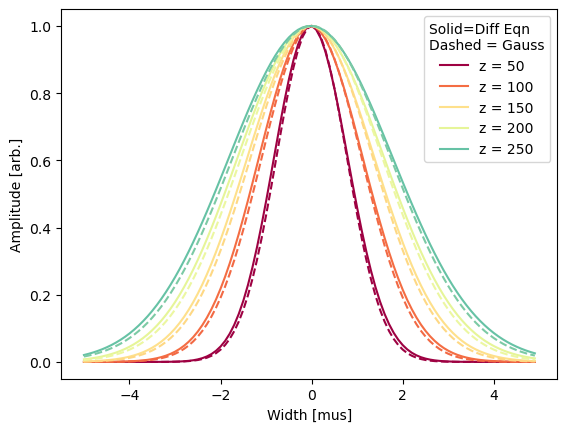

In [472]:
# Plot the function

# z = 10 # mm
v  = 0.966 # mm/mus
DL = 0.00584 # mm/mus
DT = 0.0387 # mm/mus
r0 = 1 # mm
sigma0 = 0.1 # mm

plt.figure()
cmap = get_cmap('Spectral')

zees = np.arange(50, 300, 50) # mm

for z in zees:
    drifttime = z/v # mus -- expected drift time
    t = np.arange(drifttime-5, drifttime+5, 0.1) # mus
    A = DiffModel(t, DL, DT, r0, z, v,sigma0);
    plt.plot(t- drifttime, A, label = f"z = {z}", color = cmap((z-50)/250));
    A = GausModel(t, DL, z, v, drifttime, sigma0);
    plt.plot(t- drifttime, A, color = cmap((z-50)/260), linestyle="--");
plt.legend(title="Solid=Diff Eqn\nDashed = Gauss")
plt.xlabel("Width [mus]")
plt.ylabel("Amplitude [arb.]")

plt.show()


Text(0.5, 1.0, 'Low-drift Waveform')

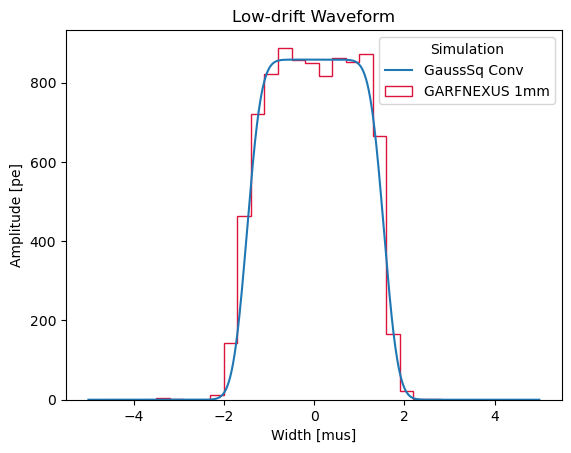

In [479]:
nexusgarf = pd.read_hdf("../data/DEMO/nexus/DEMOpp_Kr_garfnexus_merged.h5", "waveforms")
z = 1
nexusgarf = nexusgarf[nexusgarf.event_id == z]


plt.figure()

counts, bins, _ = plt.hist(nexusgarf.time_bin-(z+2.1)/.958625, weights = nexusgarf.charge, histtype = "step",  bins = np.arange(-5,5,.3), label="GARFNEXUS 1mm", color = "crimson")


# Now lets try to convolve the Gaussian eqn with a square pulse
t = np.arange(-5, +5, 0.01) # mus
convolution = GetDEMOTimingShape(t,0)

# Plot original functions and convolution
# plt.plot(t-drifttime, square_pulse*max(counts), label='Square Pulse')
plt.plot(t, convolution, label="GaussSq Conv")
plt.legend(title="Simulation")

plt.xlabel("Width [mus]")
plt.ylabel("Amplitude [pe]")
plt.title("Low-drift Waveform")

In [451]:
# Define your custom PDF
def custom_pdf(t, A, mu, sigma):
    # Define the distribution for the convolved signal
    Gauss = Gaussian_(t, A, mu, sigma)
    
    # Define the distribution for the fixed parameter
    GCS = GetDEMOTimingShape(t, mu)
    
    # Convolve the distributions
    convolved_signal = convolve(Gauss, GCS, mode='same')
    convolved_signal = A*convolved_signal/max(convolved_signal)
    
    return convolved_signal

38760


,times,sumwf,z,event
15801,395.025,0.182604,61.455658,38760
15802,395.050,-0.243129,61.455658,38760
15803,395.075,-0.185028,61.455658,38760
15804,395.100,-0.243131,61.455658,38760
15805,395.125,-0.187922,61.455658,38760
...,...,...,...,...
16595,414.875,0.360016,61.455658,38760
16596,414.900,0.361269,61.455658,38760
16597,414.925,0.142427,61.455658,38760
16598,414.950,-0.174637,61.455658,38760


[1.10203175e+03 4.04199993e+02 1.10025182e+00]


Text(0.5, 1.0, 'DEMO Run 12081 Kr Waveform')

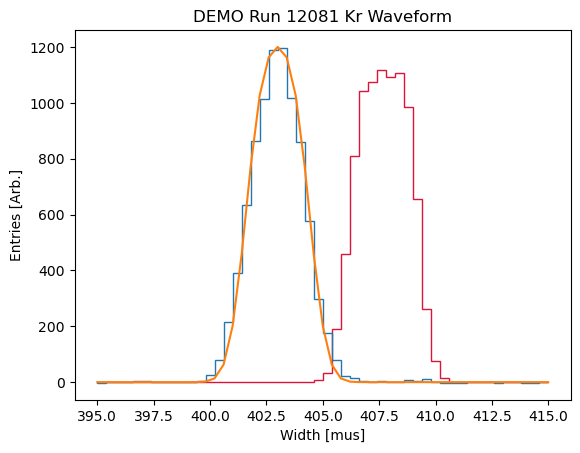

In [353]:
counter = 0
plt.figure()


z = 15
nexusgarf = pd.read_hdf("../data/DEMO/nexus/DEMOpp_Kr_garfnexus_merged.h5", "waveforms")
nexusgarf = nexusgarf[nexusgarf.event_id == z]
nexusgarf.time_bin = nexusgarf.time_bin
counts, bins, _ = plt.hist(nexusgarf.time_bin-(z+2.1)/.958625+407.6, weights = nexusgarf.charge, histtype = "step",  bins = np.linspace(395, 415, 51), label="GARFNEXUS 13mm", color = "crimson")



# plt.figure()

event_ids = wfms.event.unique()

event_ids = [38760]

rw_dfs_merge_shifted = []

for e in event_ids: 
    print(e)
    # rebin 
    df = wfms[wfms.event == e]
    display(df)

    # Plot the summed waveforms
   
    # plt.plot(df_merged.times, df_merged.sumwf)
    counts, xbins,_ = plt.hist(df.times, weights = df.sumwf, bins = np.linspace(395, 415, 51), histtype="step")

    bin_centers = xbins+ (xbins[1]-xbins[0])/2.0
    bin_centers = bin_centers[:-1]

    popt, pcov = curve_fit(custom_pdf, bin_centers, counts, bounds  = ([1100 , 404, 0], [2000, 407, 5]), maxfev=50000)
    popt_Gauss, pcov_Gauss = curve_fit(Gaussian_, bin_centers, counts, bounds  = ([0 , 395, 0], [1300, 415, 20]), maxfev=50000)
    print(popt)
    # plt.hist(df.times, weights = df.sumwf, bins = np.linspace(395, 415, 51), histtype = "step")
    t = np.linspace(395, 415, 51)
    # plt.plot(t, custom_pdf(t, popt[0],popt[1],popt[2]), label='Convolution')
    plt.plot(t, custom_pdf(t, 1200,404.4,0.57), label='Convolution')
    # plt.plot(t, Gaussian_(t, 1200,popt_Gauss[1],1.25), label='Convolution')

plt.xlabel("Width [mus]")
plt.ylabel("Entries [Arb.]")
plt.title("DEMO Run 12081 Kr Waveform")


22046
[589.00282607 404.50048371   1.99520416]


Text(0.5, 1.0, 'DEMO Run 12081 Kr Waveform')

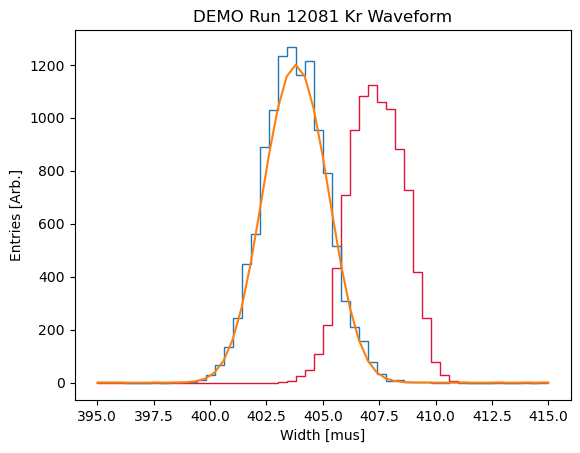

In [357]:
counter = 0
plt.figure()


z = 30
nexusgarf = pd.read_hdf("../data/DEMO/nexus/DEMOpp_Kr_garfnexus_merged.h5", "waveforms")
nexusgarf = nexusgarf[nexusgarf.event_id == z]
nexusgarf.time_bin = nexusgarf.time_bin
counts, bins, _ = plt.hist(nexusgarf.time_bin-(z+2.1)/.958625+407.6, weights = nexusgarf.charge, histtype = "step",  bins = np.linspace(395, 415, 51), label="GARFNEXUS 13mm", color = "crimson")



event_ids = wfms.event.unique()

event_ids = [22046]

rw_dfs_merge_shifted = []

for e in event_ids: 
    print(e)
    # rebin 
    df = wfms[wfms.event == e]

    # Plot the summed waveforms
   
    # plt.plot(df_merged.times, df_merged.sumwf)
    counts, xbins,_ = plt.hist(df.times, weights = df.sumwf, bins = np.linspace(395, 415, 51), histtype="step")

    bin_centers = xbins+ (xbins[1]-xbins[0])/2.0
    bin_centers = bin_centers[:-1]

    popt, pcov = curve_fit(custom_pdf, bin_centers, counts, bounds  = ([0 , 395, 0], [1000, 415, 20]), maxfev=50000)
    # popt, pcov = curve_fit(Gaussian_, bin_centers, counts, bounds  = ([0 , 395, 0], [1000, 415, 20]), maxfev=50000)
    print(popt)
    # plt.hist(df.times, weights = df.sumwf, bins = np.linspace(395, 415, 51), histtype = "step")
    t = np.linspace(395, 415, 51)
    # plt.plot(t, custom_pdf(t, popt[0],popt[1],popt[2]), label='Convolution')
    plt.plot(t, custom_pdf(t, 1200,404.6,1.1), label='Convolution')
    # plt.plot(t, Gaussian_(t, popt[0],popt[1],popt[2]), label='Convolution')

plt.xlabel("Width [mus]")
plt.ylabel("Entries [Arb.]")
plt.title("DEMO Run 12081 Kr Waveform")


38766
[499.99999987 404.86995751  10.24991652]


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_83998/1327521426.py:29: RuntimeWarning: invalid value encountered in sqrt
  plt.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', color='black', zorder=5, label="DEMO Data", markersize=5)


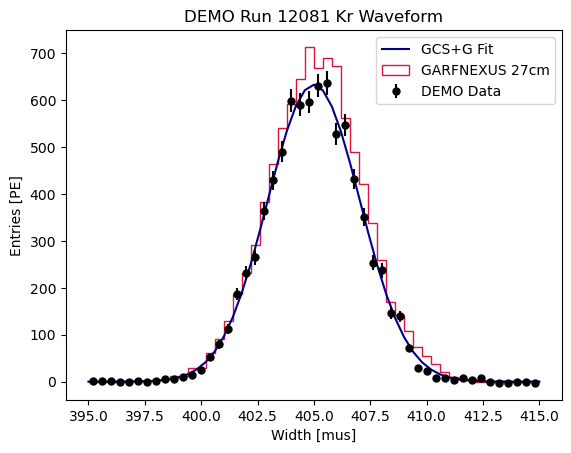

In [484]:
counter = 0
plt.figure()


z = 270
nexusgarf = pd.read_hdf("../data/DEMO/nexus/DEMOpp_Kr_garfnexus_merged.h5", "waveforms")
nexusgarf = nexusgarf[nexusgarf.event_id == z]
nexusgarf.time_bin = nexusgarf.time_bin
counts, bins, _ = plt.hist(nexusgarf.time_bin-(z+1.5)/.958625+404.3, weights = nexusgarf.charge, histtype = "step",  bins = np.linspace(395, 415, 51), label="GARFNEXUS 27cm", color = "crimson")



event_ids = wfms.event.unique()

event_ids = [38766]

rw_dfs_merge_shifted = []

for e in event_ids: 
    print(e)
    # rebin 
    df = wfms[wfms.event == e]

    # Plot the summed waveforms
   
    # plt.plot(df_merged.times, df_merged.sumwf)
    counts, bins = np.histogram(df.times, weights = df.sumwf, bins = np.linspace(395, 415, 51))
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    plt.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='o', color='black', zorder=5, label="DEMO Data", markersize=5)

    popt, pcov = curve_fit(custom_pdf, bin_centers, counts, bounds  = ([0 , 395, 0], [1000, 415, 20]), maxfev=50000)
    popt_Gauss, pcov_Gauss = curve_fit(Gaussian_, bin_centers, counts, bounds  = ([0 , 395, 0], [1000, 415, 20]), maxfev=50000)
    print(popt)
    # plt.hist(df.times, weights = df.sumwf, bins = np.linspace(395, 415, 51), histtype = "step")
    t = np.linspace(395, 415, 51)
    # plt.plot(t, custom_pdf(t, popt[0],popt[1],popt[2]), label='Convolution')
    # plt.plot(t, custom_pdf(t, 600,405,1.8), label='Convolution')
    plt.plot(t, Gaussian_(t, popt_Gauss[0],popt_Gauss[1],popt_Gauss[2]), label='GCS+G Fit',color="darkblue")

plt.xlabel("Width [mus]")
plt.ylabel("Entries [PE]")
plt.title("DEMO Run 12081 Kr Waveform")
plt.legend()


[1.99999845e+03 5.64135914e-04 2.00000000e+01]
32829.62321995441


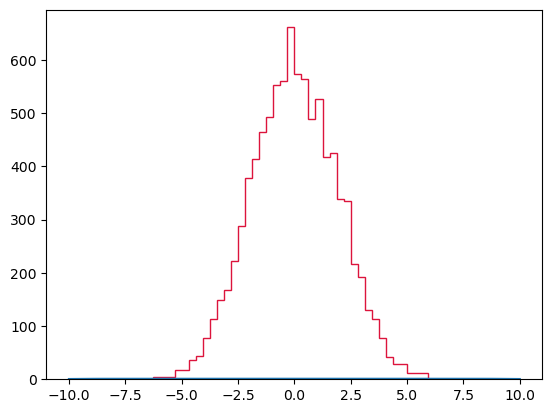

In [455]:
plt.figure()


z = 200
nexusgarf = pd.read_hdf("../data/DEMO/nexus/DEMOpp_Kr_garfnexus_merged.h5", "waveforms")
nexusgarf = nexusgarf[nexusgarf.event_id == z]
nexusgarf.time_bin = nexusgarf.time_bin
counts, bins, _ = plt.hist(nexusgarf.time_bin -z/.958625-5/2.2, weights = nexusgarf.charge, histtype = "step",  bins = np.linspace(-10, 10, 65), label="GARFNEXUS 13mm", color = "crimson")
bin_centers = 0.5 * (bins[:-1] + bins[1:])

t = np.linspace(-10, 10, 51)
popt, pcov = curve_fit(custom_pdf, bin_centers, counts, bounds  = ([0 , -0.001, 0], [2000, 0.001, 20]), maxfev=50000)
print(popt)
plt.plot(t, custom_pdf(t, popt[0],popt[1],popt[2]), label='Convolution')
# plt.plot(t, custom_pdf(t,650,0,1.7), label='Convolution')
print(.958625*popt[2]**2/(2*DL ))